In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [16]:
#spacy for lemmatization
import spacy


In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Remove deprecationWarning that I can't fix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

/Users/root1/Development/lda/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# NLTK for removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance', 'thereof', 'section', 'municipal', 'municipality', 'government'])

In [36]:
# Import CSV Ordinance Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [37]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [38]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# Remove words ending with ING like amending, regulating
# Implemtation to be improved / Seems to improve topics
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]


pprint(data[:5])

['“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES '
 'ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) '
 'ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE '
 'UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, '
 'REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE '
 'PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS '
 'MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”.',
 'AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE '
 'NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT '
 'BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS '
 '(P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF '
 'SERVICE VEHICLES, ACQUISITION O

In [39]:
#preprocess using gensim simple_preprocess and tokenize into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:5])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang'],
 ['an',
  'ordinance',
  'the',
  'members',
  'of',
  'the',
  'city',
  'tricycle',
  'and',
  'regulatory',
  'board',
  'ctfrb',
  'its',
  'functions',
  'and',
  'procedures',
  'and',
  'motorized',
  'tricycle',
  'for',
  'hire',
  'mth',
  'tricycle',
  'utility',
  'vehicle',
  'tuv',
  'and',
  'tricycle',
  'utility',
  'for',
  'hire',
  'tuh',
  'guidelines',
  'regulations',
  'and',
  'operations',
  'the',
  'collection',
  'of',
  'fees',
  'charges',
  'administrative',
  'provisions',
  'and',
  'penalties',
  'for',
  'violation',
  'thereof'],
 ['an',
  'ordinance',
  'funeral',
  'and',
  'burial',
  'assistance',
  'for',
  'indigent',
  'tagumenyos',
  'its',
  'management',
  'procedures',
  'and',
  'guidelines',
  'and',
  'funds',
  'theref

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [41]:

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['an',
 'ordinance',
 'the',
 'practice',
 'of',
 'traditional',
 'home',
 'birth',
 'delivery',
 'or',
 'deliveries',
 'attended',
 'by',
 'traditional',
 'birth',
 'attendant',
 'or',
 'mananabang']


In [74]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Code snippets from Selva Prabhakaran | Topic Modeling with Gensim (Python)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stemmer(texts):
    new_list = []
    temp = []
    for lists in texts:
        new_list.append(temp)
        for word in lists:
            temp.append(ps.stem(word))
        temp = []
    return new_list

In [84]:
# Remove Stop Words and Form Bigrams
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# # If stemming
# # data_stemmed = stemmer(data_words_bigrams)

# Lematize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:1])

[['practice',
  'traditional',
  'home',
  'birth',
  'delivery',
  'delivery',
  'attend',
  'traditional',
  'birth',
  'attendant',
  'mananabang']]


In [85]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)]]


In [86]:
id2word[0]

'attend'

In [87]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('birth', 2),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [113]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [114]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.053*"position" + 0.050*"tax" + 0.031*"legislative" + 0.030*"officer" + 0.029*"necessary" + 0.028*"department" + 0.025*"code" + 0.025*"sangguniang" + 0.024*"salary" + 0.020*"article"'), (1, '0.028*"violation" + 0.027*"utility" + 0.027*"barangay" + 0.026*"tricycle" + 0.023*"road" + 0.021*"implementation" + 0.020*"national" + 0.019*"revised" + 0.019*"industrial" + 0.017*"garbage"'), (2, '0.063*"pesos" + 0.050*"mayor" + 0.048*"amount" + 0.022*"augment" + 0.021*"permit" + 0.020*"appropriation" + 0.019*"year" + 0.017*"assistance" + 0.016*"construction" + 0.014*"burial"'), (3, '0.034*"purpose" + 0.030*"business" + 0.029*"fee" + 0.023*"bonifacio" + 0.022*"certain" + 0.019*"act" + 0.019*"park" + 0.015*"town" + 0.014*"closed" + 0.013*"inspection"'), (4, '0.085*"office" + 0.060*"market" + 0.046*"public" + 0.033*"series" + 0.030*"barangay" + 0.027*"development" + 0.025*"new" + 0.023*"service" + 0.023*"traffic" + 0.020*"medical"'), (5, '0.039*"public" + 0.038*"operation" + 0.036*"violation"

In [115]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.54818957726431

Coherence Score:  0.6071837956768796


In [116]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.260005 -0.068279       1        1  25.555046
4     -0.062178  0.249601       2        1  16.330030
1     -0.067062 -0.107052       3        1  15.656745
2      0.129298 -0.158486       4        1  14.945888
0      0.131991  0.075284       5        1  14.407283
3      0.127957  0.008931       6        1  13.105008, topic_info=         Term       Freq      Total Category  logprob  loglift
123    office  61.000000  61.000000  Default  30.0000  30.0000
686     pesos  42.000000  42.000000  Default  29.0000  29.0000
363    market  44.000000  44.000000  Default  28.0000  28.0000
142    public  77.000000  77.000000  Default  27.0000  27.0000
358  position  34.000000  34.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
645    memory   3.574231   4.239264   Topic6  -5.0857   1.8615
517        tv   3.545310   4.208740   Topic6  -5.0938   1.8606
791       may   3.549100   4.213557   Topic6  -5.0928   1.8606
968   pioneer   5.061122   7.119395   Topic6  -4.7379   1.6909
345     honor   4.389675   6.663893   Topic6  -4.8802   1.6147

[247 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
79        6  0.924989             act
350       5  0.872635      additional
557       2  0.800465  administration
557       5  0.133411  administration
8         3  0.957093  administrative
...     ...       ...             ...
190       3  0.916218           waste
107       2  0.821253         welfare
53        4  0.977242            year
78        1  0.657516            zone
78        3  0.328758            zone

[233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 2, 3, 1, 4])

In [69]:
# Build Mallet LDA Model
mallet_path = '/Users/root1/Development/lda/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [70]:
# Show Topics
# Only few topics make sense for me
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, corpus=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('violation', 0.09309791332263243),
   ('penalties', 0.0754414125200642),
   ('fees', 0.060995184590690206),
   ('tricycle', 0.04012841091492777),
   ('regulations', 0.04012841091492777),
   ('functions', 0.038523274478330656),
   ('motorized', 0.030497592295345103),
   ('board', 0.027287319422150885),
   ('hire', 0.027287319422150885),
   ('students', 0.02247191011235955)]),
 (0,
  [('public', 0.11620294599018004),
   ('school', 0.06873977086743044),
   ('vehicles', 0.04582651391162029),
   ('norte', 0.03436988543371522),
   ('national', 0.03436988543371522),
   ('del', 0.03273322422258593),
   ('private', 0.022913256955810146),
   ('roads', 0.022913256955810146),
   ('educational', 0.01800327332242226),
   ('province', 0.016366612111292964)]),
 (6,
  [('violations', 0.06643952299829642),
   ('health', 0.03577512776831346),
   ('business', 0.03577512776831346),
   ('establishments', 0.034071550255536626),
   ('jurisdiction', 0.028960817717206135),
   ('territorial', 0.02896081

In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

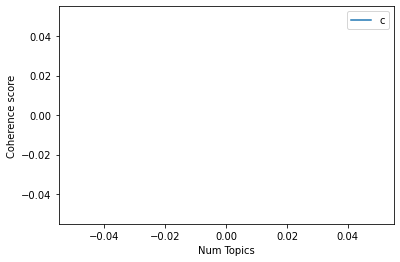

In [60]:
# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores with increasing number of topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of nan
Num Topics = 8  has Coherence Value of nan
Num Topics = 14  has Coherence Value of nan
Num Topics = 20  has Coherence Value of nan
Num Topics = 26  has Coherence Value of nan
Num Topics = 32  has Coherence Value of nan
Num Topics = 38  has Coherence Value of nan


In [62]:
# Select the model and print the topics
optimal_model = model_list[2] # when number of topics is 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.066*"street" + 0.062*"portion" + 0.055*"road" + 0.043*"streets" + '
  '0.028*"bonifacio" + 0.028*"traffic" + 0.025*"temporary" + 0.023*"park" + '
  '0.021*"village" + 0.019*"sobrecarey"'),
 (1,
  '0.085*"school" + 0.043*"business" + 0.043*"national" + 0.037*"elementary" + '
  '0.030*"fee" + 0.030*"year" + 0.024*"high" + 0.022*"permit" + 0.020*"center" '
  '+ 0.018*"maintenance"'),
 (2,
  '0.203*"funds" + 0.047*"assistance" + 0.040*"medical" + 0.036*"burial" + '
  '0.027*"therefor" + 0.024*"financial" + 0.022*"death" + 0.022*"officials" + '
  '0.018*"festival" + 0.018*"nutrition"'),
 (3,
  '0.083*"code" + 0.072*"tax" + 0.039*"article" + 0.033*"chapter" + '
  '0.028*"ord" + 0.028*"economic" + 0.026*"comprehensive" + 0.026*"garbage" + '
  '0.026*"purok" + 0.022*"mun"'),
 (4,
  '0.091*"pesos" + 0.083*"mayor" + 0.069*"thousand" + 0.065*"amount" + '
  '0.059*"office" + 0.031*"hon" + 0.029*"augment" + 0.026*"appropriation" + '
  '0.020*"expenses" + 0.018*"vice"'),
 (5,
  '0.099*"ope

In [63]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1369,"funds, assistance, medical, burial, therefor, ...",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME...
1,1,12.0,0.3504,"violation, penalties, fees, functions, tricycl...",“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE...
2,2,2.0,0.1429,"funds, assistance, medical, burial, therefor, ...",“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FO...
3,3,8.0,0.1379,"lot, area, meters, reading, continue, tct, squ...","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 A..."
4,4,12.0,0.0847,"violation, penalties, fees, functions, tricycl...","“AN ORDINANCE THE CITY HISTORICAL, CULTURAL AN..."
5,5,2.0,0.1056,"funds, assistance, medical, burial, therefor, ...",“AN ORDINANCE THE HUGPONG SERBISYO PARA SA TAG...
6,6,0.0,0.0958,"street, portion, road, streets, bonifacio, tra...",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORI...
7,7,6.0,0.1631,"regulations, implementation, program, act, rev...",AN ORDINANCE SECTION 2 OF CITY ORDINANCE NO. 2...
8,8,0.0,0.1832,"street, portion, road, streets, bonifacio, tra...",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS...
9,9,0.0,0.3047,"street, portion, road, streets, bonifacio, tra...",“AN ORDINANCE TEMPORARY CLOSURE FROM CORNER R...


In [64]:
# Convert malletmodel to to gensim lda model for pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/Users/root1/Development/lda/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/root1/Development/lda/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/root1/Development/lda/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.019044 -0.006210       1        1  4.059904
13    -0.055611 -0.055208       2        1  3.719809
24    -0.059404 -0.065952       3        1  3.665433
19     0.123159 -0.013949       4        1  3.540500
10     0.019340  0.371545       5        1  3.498453
25    -0.028202 -0.008506       6        1  3.475557
6     -0.109691 -0.061820       7        1  3.456792
9     -0.067464 -0.021907       8        1  3.445010
12    -0.038934 -0.000836       9        1  3.434593
2     -0.044202 -0.029197      10        1  3.333662
16     0.018137 -0.033089      11        1  3.317359
5     -0.037826 -0.041503      12        1  3.313521
8      0.191660 -0.060090      13        1  3.298730
3      0.020537  0.379761      14        1  3.296813
21    -0.084578 -0.049013      15        1  3.293950
7     -0.013817 -0.037286      16        1  3.262477
11    -0.082867  0.012149      17        1  3.246784
28     0.012341  0.115889      18        1  3.238090
14    -0.026455 -0.014850      19        1  3.236056
22     0.009953 -0.048759      20        1  3.218235
15    -0.120734 -0.055214      21        1  3.210965
26    -0.066370 -0.016498      22        1  3.208030
17     0.321392 -0.048119      23        1  3.200661
29     0.036042 -0.028449      24        1  3.198977
20    -0.139796 -0.043106      25        1  3.194830
27     0.004833  0.013232      26        1  3.185878
23    -0.072450 -0.034412      27        1  3.179035
18     0.010219 -0.030700      28        1  3.105894
4      0.327533 -0.074922      29        1  3.095700
1     -0.027702 -0.012981      30        1  3.068302, topic_info=            Term        Freq       Total Category  logprob  loglift
22     penalties  100.000000  100.000000  Default  30.0000  30.0000
35         funds  122.000000  122.000000  Default  29.0000  29.0000
99      barangay  112.000000  112.000000  Default  28.0000  28.0000
262       public   75.000000   75.000000  Default  27.0000  27.0000
16    guidelines   66.000000   66.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
232   commercial    2.553474   18.106064  Topic30  -4.5539   1.5253
545     services    1.276737   13.062503  Topic30  -5.2470   1.1586
581  procurement    1.276737    2.379507  Topic30  -5.2470   2.8615
719       supply    1.276737    2.162544  Topic30  -5.2470   2.9571
822         juke    1.276737    2.484133  Topic30  -5.2470   2.8184

[1610 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1341     30  0.783247       abad
1653     20  0.966853  abandoned
1752     12  0.973405   abbatoir
1316     11  1.149577      abuse
784      22  0.835874       acas
...     ...       ...        ...
173       5  0.878535       zone
173      14  0.043927       zone
173      17  0.043927       zone
173      23  0.043927       zone
1504     13  1.104305      zones

[1766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 14, 25, 20, 11, 26, 7, 10, 13, 3, 17, 6, 9, 4, 22, 8, 12, 29, 15, 23, 16, 27, 18, 30, 21, 28, 24, 19, 5, 2])